## veri setini oluşturma

In [18]:
import numpy as np
import requests
import tensorflow as tf
import requests, string
text = open("kutatgu bilig.txt", "r")
"""
r = requests.get("https://data.heatonresearch.com/data/t81-558/text/"\
                 "treasure_island.txt")

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text1 = open(path_to_file, 'rb').read().decode(encoding='utf-8')

text2=r.text"""

#text3 = open("test_text (2).txt", "r")

In [21]:
vocab = sorted(set(text))
print(f'{len(vocab)} farklı karakter')
print(vocab)

89 farklı karakter
['\t', '\n', '\x0c', ' ', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'Â', 'Ç', 'Ö', 'Ü', 'â', 'ç', 'î', 'ö', 'û', 'ü', 'ğ', 'İ', 'ı', 'Ş', 'ş', '‘', '’', '“', '”', '■']


In [22]:
ids_from_chars  =tf.keras.layers.StringLookup(
    vocabulary=list(vocab)
)

In [23]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

In [24]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(534027,), dtype=int64, numpy=array([ 2,  2, 23, ...,  2,  2,  3])>

In [25]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [26]:
seq_length = 100
examples_per_epoch = len(text)

In [27]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [28]:
def create_inputand_label(sequences):
  """
  Örnek 
  input:Merhab
  label:erhaba
  input en başından sondan 2. harfe kadar (-1 son harf oluyor)
  label 2.harften son harfe kadar (:1 1 den sonrası oluyor)
  """
  input=sequences[:-1]
  label=sequences[1:]
  return input,label

In [29]:
create_inputand_label(list("Merhaba"))

(['M', 'e', 'r', 'h', 'a', 'b'], ['e', 'r', 'h', 'a', 'b', 'a'])

In [30]:
dataset=sequences.map(create_inputand_label)

In [31]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [32]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\n\nBismillahirrahmanirrahim\nHamd, \xc5\x9f\xc3\xbck\xc3\xbcr, minnet ve sonsuz \xc3\xb6vg\xc3\xbc Allah azze ve celleye ki o\nululuk sahi'
Target: b'\nBismillahirrahmanirrahim\nHamd, \xc5\x9f\xc3\xbck\xc3\xbcr, minnet ve sonsuz \xc3\xb6vg\xc3\xbc Allah azze ve celleye ki o\nululuk sahib'


In [33]:
BATCH_SİZE=64

dataset = (
    dataset
    .shuffle(1000)
    .batch(1000, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((1000, 100), (1000, 100)), types: (tf.int64, tf.int64)>

In [34]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [35]:
model11 = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=256,
    rnn_units=1024)

In [36]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [37]:
model11.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
import os
checkpoint_dir = '/content/checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [39]:
history = model11.fit(dataset, epochs=700, callbacks=[checkpoint_callback])

Epoch 1/700
5/5 [==============================] - 15s 1s/step - loss: 6.8443
Epoch 2/700
5/5 [==============================] - 8s 1s/step - loss: 8.5977
Epoch 3/700
5/5 [==============================] - 8s 2s/step - loss: 4.5962
Epoch 4/700
5/5 [==============================] - 7s 1s/step - loss: 3.7240
Epoch 5/700
5/5 [==============================] - 8s 2s/step - loss: 3.4954
Epoch 6/700
5/5 [==============================] - 8s 2s/step - loss: 3.8617
Epoch 7/700
5/5 [==============================] - 9s 2s/step - loss: 3.6779
Epoch 8/700
5/5 [==============================] - 8s 2s/step - loss: 3.4189
Epoch 9/700
5/5 [==============================] - 7s 1s/step - loss: 3.2265
Epoch 10/700
5/5 [==============================] - 8s 2s/step - loss: 3.0776
Epoch 11/700
5/5 [==============================] - 8s 1s/step - loss: 2.9728
Epoch 12/700
5/5 [==============================] - 8s 2s/step - loss: 2.8894
Epoch 13/700
5/5 [==============================] - 8s 2s/step - loss: 2

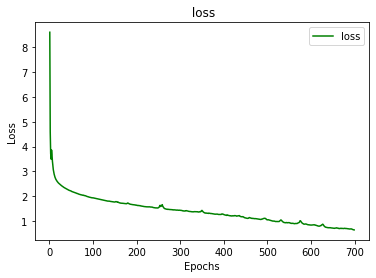

In [113]:
import matplotlib.pyplot as plt

def plot_loss(first_epoch=1,last_epoch=700):
  loss_train = history.history['loss']
  epochs = range(first_epoch,last_epoch)
  plt.plot(epochs, loss_train[first_epoch:last_epoch], 'g', label='loss')

  plt.title(' loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
plot_loss(1,700)

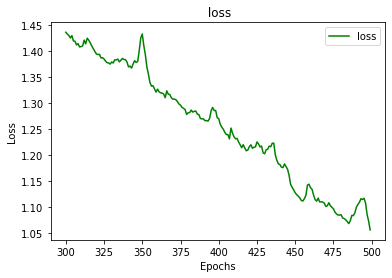

In [114]:
plot_loss(300,500)

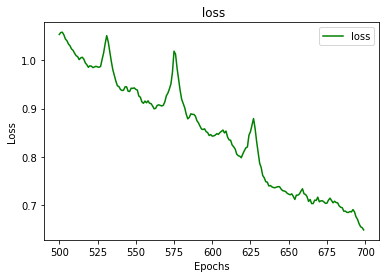

In [115]:
plot_loss(500,700)

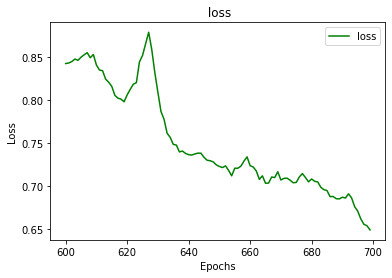

In [119]:
plot_loss(600,700)

In [40]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

   
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(

        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
 
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):

    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
   
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
   
    predicted_logits = predicted_logits + self.prediction_mask


    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

   
    predicted_chars = self.chars_from_ids(predicted_ids)


    return predicted_chars, states

In [41]:
one_step_model = OneStep(model11, chars_from_ids, ids_from_chars)

In [95]:
from re import A
import time
start = time.time()
states = None
next_char = tf.constant(['A'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)


result = result[0].numpy().decode('utf-8')+"\n"
result = ''.join([i for i in result if not i.isdigit()])
end = time.time()
print(result+"_"*80)
print('\nRun time:', end - start)

Allah sanır analır malını
Kendi zor bullarında gel cefa
 Uya cevabını topacukça
Geçemezlik mı hazır hazirde
 Kişi açık ve ahçittse bugün gönlü ucuz
Ölür kişiye düşmanı yedirse
Alk istiyorsan, gözetmelidir, doğru tut ağarırdı
***
 Gönlümü ve asla zevvili halkın başıdır sana ey kardeş
İyi olur düş, ey bir ve bütün iyiliğin koru
 Ku şümün kendisi yok ey bak oturdu
Kavur, huzur için doğruluk yolunlar sana
 Gün geçti onu yollan bayvan onlara oldu, malıvarak

Yusuf Has Hacib ■

 Bütün iyilikler onu ey hazca
Güne düşün suyunurdı sen binde
 Ulular sana düş gibidir avuam gelir
İnsanların serayıdır hazır tut, onları, doğrustan ey gönlü kattı
 Geniş verilmeyen kişiyi kut bu ün üzerinde
Hevriya giysisini vurular ve bozup aramazın
 Kıyarı suya versen ormak iyi anlaydı, bunurdu bunca
Ayrasın sevinci bu adı sen işte ve kutu
 Yine seni bularsa olduğu olsun, orsunu, bak karat elinin
Kendini uzat ediplik, yet mık kalarsan bak tasiyeceği
 Çok göster başka olmas
__________________________________________

In [47]:
model11.save_weights('./checkpoints/my_checkpoint')

In [44]:
model11.save_weights('./checkpoints/my_checkpoint')

In [50]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [51]:
from google.colab import files
files.download('/content/saved_model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>